# Federated Learning of a Recurrent Neural Network for text classification

In this tutorial, you are going to learn how to train a Recurrent Neural Network (RNN) in a federated way with the purpose of *classifying* a person's surname to its most likely language of origin. 


We will train two Recurrent Neural Networks residing on two remote workers based on a dataset containing approximately 20.000 surnames from 18 languages of origin, and predict to which language a name belongs based on the name's spelling. 

A **character-level RNN** treats words as a series of characters - outputting a prediction and “hidden state” per character, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to. Hence the training process proceeds sequentially character-by-character through the different hidden layers.

Following distributed training, the resulting models are going to be able to perform operations like the following ones:

```python
predict(model_pointers["bob"], "Qing", alice) #alice is our worker

 Qing
(-1.43) Korean
(-1.74) Vietnamese
(-2.18) Arabic

predict(model_pointers["alice"], "Daniele", alice)

 Daniele
(-1.58) French
(-2.04) Scottish
(-2.07) Dutch
```

The present example is inspired by an official Pytorch [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), which I ported to PySyft with  the purpose of learning a Recurrent Neural Network in a federated way.The present tutorial is self-contained, so there are no dependencies on external pieces of code apart from a few Python libraries.

**RNN Tutorial's author**: Daniele Gadler. [@DanyEle](https://github.com/danyele) on Github.


## 1. Step: Dependencies!

Make sure you have all the requires packages installed, or install them via the following command (assuming you didn't move the current Jupyter Notebook from its directory. After installing new packages, you may have to restart your Notebook Kernel.

In [1]:
pip install -r "../../../requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset

import torch
from io import open
import glob
import os
import numpy as np
import unicodedata
import string
import random
import torch.nn as nn
import time
import math
import syft as sy
import pandas as pd
import random
from syft.frameworks.torch.federated import utils

from syft.workers import WebsocketClientWorker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## 2. Step: Data pre-processing and transformation

We are going to train our neural network based on a dataset containing surnames from 18 languages of origin, so download the following dataset [LINK](https://download.pytorch.org/tutorial/data.zip) and extract it to the same directory of this Jupyter notebook. After you've extracted the data, you'll be able to read it in Python after initializing a few basic functions for parsing the data

In [3]:
#Load all the files in a certain path
def findFiles(path):
    return glob.glob(path)

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#convert a string 's' in unicode format to ASCII format
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#dictionary containing the nation as key and the names as values
#Example: category_lines["italian"] = ["Abandonato","Abatangelo","Abatantuono",...]
category_lines = {}
#List containing the different categories in the data
all_categories = []

for filename in findFiles('data/names/*.txt'):
    print(filename)
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines   
    
n_categories = len(all_categories)

print("Amount of categories:" + str(n_categories))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt
Amount of categories:18


Now we are going to format the data so as to make it compliant with the format requested by PySyft and Pytorch. Firstly, we define a dataset class, specifying how batches ought to be extracted from the dataset in order for them to be assigned to the different workers.

In [5]:
class LanguageDataset(Dataset):
    #Constructor is mandatory
        def __init__(self, text, labels, transform=None):
            self.data = text
            self.targets = labels #categories
            #self.to_torchtensor()
            self.transform = transform
        
        def to_torchtensor(self):            
            self.data = torch.from_numpy(self.text, requires_grad=True)
            self.labels = torch.from_numpy(self.targets, requires_grad=True)
        
        def __len__(self):
            #Mandatory
            '''Returns:
                    Length [int]: Length of Dataset/batches
            '''
            return len(self.data)
    
        def __getitem__(self, idx): 
            #Mandatory 
            
            '''Returns:
                     Data [Torch Tensor]: 
                     Target [ Torch Tensor]:
            '''
            sample = self.data[idx]
            target = self.targets[idx]
                    
            if self.transform:
                sample = self.transform(sample)
    
            return sample,target

In [6]:
#The list of arguments for our program. We will be needing most of them soon.
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.learning_rate = 0.005
        self.epochs = 10000
        self.federate_after_n_batches = 15000
        self.seed = 1
        self.print_every = 200
        self.plot_every = 100
        self.use_cuda = False
        
args = Arguments()


We now need to unwrap data samples so as to have them all in one single list instead of a dictionary,where different categories were addressed by key.From now onwards, **categories** will be the languages of origin (Y) and **names** will be the data points (X).

In [7]:
%%latex

\begin{split}
names\_list = [d_1,...,d_n]  \\

category\_list = [c_1,...,c_n] 
\end{split}


Where $n$ is the total amount of data points

<IPython.core.display.Latex object>

In [8]:
#Set of names(X)
names_list = []
#Set of labels (Y)
category_list = []

#Convert into a list with corresponding label.

for nation, names in category_lines.items():
    #iterate over every single name
    for name in names:
        names_list.append(name)      #input data point
        category_list.append(nation) #label
        
#let's see if it was successfully loaded. Each data sample(X) should have its own corresponding category(Y)
print(names_list[1:20])
print(category_list[1:20])

print("\n \n Amount of data points loaded: " + str(len(names_list)))



['Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky']
['Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech', 'Czech']

 
 Amount of data points loaded: 20074


We now need to turn our categories into numbers, as PyTorch cannot really understand plain text

For an example category: "Greek" ---> 0

In [9]:
#Assign an integer to every category
categories_numerical = pd.factorize(category_list)[0]
#Let's wrap our categories with a tensor, so that it can be loaded by LanguageDataset
category_tensor = torch.tensor(np.array(categories_numerical), dtype=torch.long)
#Ready to be processed by torch.from_numpy in LanguageDataset
categories_numpy = np.array(category_tensor)

#Let's see a few resulting categories
print(names_list[1200:1210])
print(categories_numpy[1200:1210])



['Wedekind', 'Weeber', 'Wegener', 'Wegner', 'Wehner', 'Wehunt', 'Weigand', 'Weiman', 'Weiner', 'Weiss']
[1 1 1 1 1 1 1 1 1 1]


We now need to turn every single character in each input line string into a vector, with a "1" marking the character present in that very character.

For example, in the case of a single character, we have:

"a" = array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)


A word is just a vector of such character vectors: our Recurrent Neural Network will process every single character vector in the word, producing an output after passing through each of its hidden layers. 

This technique, involving the encoding of a word as a vector of character vectors, is known as *word embedding*, as we embed a word into a vector of vectors.

In [11]:
def letterToIndex(letter):
    return all_letters.find(letter)
    
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) #Daniele: len(max_line_size) was len(line)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    #Daniele: add blank elements over here
    return tensor    
    
    
    
def list_strings_to_list_tensors(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensor(line)
        lineNumpy = lineTensor.numpy()
        lines_tensors.append(lineNumpy)
        
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors(names_list)

print(names_list[0])
print(lines_tensors[0])
print(lines_tensors[0].shape)



Abl
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(3, 1, 57)


Let's now identify the longest word in the dataset, as all tensors need to have the same shape  in order to fit into a numpy array. So, we append vectors containing just "0"s into our words up to the maximum word size, such that all word embeddings have the same shape.

In [13]:

max_line_size = max(len(x) for x in lines_tensors)

def lineToTensorFillEmpty(line, max_line_size):
    tensor = torch.zeros(max_line_size, 1, n_letters) #notice the difference between this method and the previous one
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
        #Vectors with (0,0,.... ,0) are placed where there are no characters
    return tensor

def list_strings_to_list_tensors_fill_empty(names_list):
    lines_tensors = []
    for index, line in enumerate(names_list):
        lineTensor = lineToTensorFillEmpty(line, max_line_size)
        lines_tensors.append(lineTensor)
    return(lines_tensors)

lines_tensors = list_strings_to_list_tensors_fill_empty(names_list)

#Let's take a look at what a word now looks like
print(names_list[0])
print(lines_tensors[0])
print(lines_tensors[0].shape)

Abl
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([19, 1, 57])


In [14]:
#And finally, from a list, we can create a numpy array with all our word embeddings having the same shape:
array_lines_tensors = np.stack(lines_tensors)
#However, such operation introduces one extra dimension (look at the dimension with index=2 having size '1')
print(array_lines_tensors.shape)
#Because that dimension just has size 1, we can get rid of it with the following function call
array_lines_proper_dimension = np.squeeze(array_lines_tensors, axis=2)
print(array_lines_proper_dimension.shape)



(20074, 19, 1, 57)
(20074, 19, 57)


### Data unbalancing and batch randomization:
You may have noticed that our dataset is strongly unbalanced and contains a lot of data points in the "russian.txt" dataset. However, we would still like to take a random batch during our training procedure at every iteration. In order to prevent our neural network from classifying a data point as always belonging to the "Russian" category, we first pick a random category and then select a data point from that category. To do that, we construct a dictionary mapping a certain category to the corresponding starting index in the list of data points (e.g.: lines). Afterwards, we will take a datapoint starting from the starting_index identified

In [15]:
def find_start_index_per_category(category_list):
    categories_start_index = {}
    
    #Initialize every category with an empty list
    for category in all_categories:
        categories_start_index[category] = []
    
    #Insert the start index of each category into the dictionary categories_start_index
    #Example: "Italian" --> 203
    #         "Spanish" --> 19776
    last_category = None
    i = 0
    for name in names_list:
        cur_category = category_list[i]
        if(cur_category != last_category):
            categories_start_index[cur_category] = i
            last_category = cur_category
        
        i = i + 1
        
    return(categories_start_index)

categories_start_index = find_start_index_per_category(category_list)

print(categories_start_index)


{'Czech': 0, 'German': 519, 'Arabic': 1243, 'Japanese': 3243, 'Chinese': 4234, 'Vietnamese': 4502, 'Russian': 4575, 'French': 13983, 'Irish': 14260, 'English': 14492, 'Spanish': 18160, 'Greek': 18458, 'Italian': 18661, 'Portuguese': 19370, 'Scottish': 19444, 'Dutch': 19544, 'Korean': 19841, 'Polish': 19935}


Let's define a few functions to take a random index from from the dataset, so that we'll be able to select a random data point and a random category.

In [16]:
def randomChoice(l):
    rand_value = random.randint(0, len(l) - 1)
    return l[rand_value], rand_value


def randomTrainingIndex():
    category, rand_cat_index = randomChoice(all_categories) #cat = category, it's not a random animal
    #rand_line_index is a relative index for a data point within the random category rand_cat_index
    line, rand_line_index = randomChoice(category_lines[category])
    category_start_index = categories_start_index[category]
    absolute_index = category_start_index + rand_line_index
    return(absolute_index)

## 3. Step: Model - Recurrent Neural Network
Hey, I must admit that was indeed a lot of data preprocessing and transformation, but it was well worth it! 
We have defined almost all the function we'll be needing during the training procedure and our data is ready
to be fed into the neural network, which we're creating now:

In [17]:
#Two hidden layers, based on simple linear layers

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#Let's instantiate the neural network already:
n_hidden = 128
#Instantiate RNN

device = torch.device("cuda" if args.use_cuda else "cpu")
model = RNN(n_letters, n_hidden, n_categories).to(device)
#The final softmax layer will produce a probability for each one of our 18 categories
print(model)    
    

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


In [18]:
#Now let's define our workers. You can either use remote workers or virtual workers
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
#alice = sy.VirtualWorker(hook, id="alice")  
bob = sy.VirtualWorker(hook, id="bob")  
#charlie = sy.VirtualWorker(hook, id="charlie") 

#workers_virtual = [alice, bob]

#If you have your workers operating remotely, like on Raspberry PIs
kwargs_websocket_alice = {"host": "192.168.2.106", "hook": hook}
alice = WebsocketClientWorker(id="alice", port=8777, **kwargs_websocket_alice)
#kwargs_websocket_bob = {"host": "ip_bob", "hook": hook}
#bob = WebsocketClientWorker(id="bob", port=8778, **kwargs_websocket_bob)
workers_virtual = [alice, bob]

In [19]:
#array_lines_proper_dimension = our data points(X)
#categories_numpy = our labels (Y)
langDataset =  LanguageDataset(array_lines_proper_dimension, categories_numpy)

#assign the data points and the corresponding categories to workers.
federated_train_loader = sy.FederatedDataLoader(
            langDataset
            .federate(workers_virtual),
            batch_size=args.batch_size)  


## 4. Step - Model Training!


It's now time to train our Recurrent Neural Network based on the processed data. To do that, we need to define a few more functions

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def fed_avg_every_n_iters(model_pointers, iter, federate_after_n_batches):
        models_local = {}
        
        if(iter % args.federate_after_n_batches == 0):
            for worker_name, model_pointer in model_pointers.items():
#                #need to assign the model to the worker it belongs to.
                models_local[worker_name] = model_pointer.copy().get()
            model_avg = utils.federated_avg(models_local)
           
            for worker in workers_virtual:
                model_copied_avg = model_avg.copy()
                model_ptr = model_copied_avg.send(worker) 
                model_pointers[worker.id] = model_ptr
                
        return(model_pointers)     

def fw_bw_pass_model(model_pointers, line_single, category_single):
    #get the right initialized model
    model_ptr = model_pointers[line_single.location.id]   
    line_reshaped = line_single.reshape(max_line_size, 1, len(all_letters))
    line_reshaped, category_single = line_reshaped.to(device), category_single.to(device)
    #Firstly, initialize hidden layer
    hidden_init = model_ptr.initHidden() 
    #And now zero grad the model
    model_ptr.zero_grad()
    hidden_ptr = hidden_init.send(line_single.location)
    amount_lines_non_zero = len(torch.nonzero(line_reshaped.copy().get()))
    #now need to perform forward passes
    for i in range(amount_lines_non_zero): 
        output, hidden_ptr = model_ptr(line_reshaped[i], hidden_ptr) 
    criterion = nn.NLLLoss()   
    loss = criterion(output, category_single) 
    loss.backward()
    
    model_got = model_ptr.get() 
    
    #Perform model weights' updates    
    for param in model_got.parameters():
        param.data.add_(-args.learning_rate, param.grad.data)
        
        
    model_sent = model_got.send(line_single.location.id)
    model_pointers[line_single.location.id] = model_sent
    
    return(model_pointers, loss, output)
            
  
    
def train_RNN(n_iters, print_every, plot_every, federate_after_n_batches, list_federated_train_loader):
    current_loss = 0
    all_losses = []    
    
    model_pointers = {}
    
    #Send the initialized model to every single worker just before the training procedure starts
    for worker in workers_virtual:
        model_copied = model.copy()
        model_ptr = model_copied.send(worker) 
        model_pointers[worker.id] = model_ptr

    #extract a random element from the list and perform training on it
    for iter in range(1, n_iters + 1):        
        random_index = randomTrainingIndex()
        line_single, category_single = list_federated_train_loader[random_index]
        #print(category_single.copy().get())
        line_name = names_list[random_index]
        model_pointers, loss, output = fw_bw_pass_model(model_pointers, line_single, category_single)
        #model_pointers = fed_avg_every_n_iters(model_pointers, iter, args.federate_after_n_batches)
        #Update the current loss a
        loss_got = loss.get().item() 
        current_loss += loss_got
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
             
        if(iter % print_every == 0):
            output_got = output.get()  #Without copy()
            guess, guess_i = categoryFromOutput(output_got)
            category = all_categories[category_single.copy().get().item()]
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss_got, line_name, guess, correct))
    return(all_losses, model_pointers)

In order for the defined randomization process to work, we need to wrap the data points and categories into a list, from that we're going to take a batch at a random index.


In [21]:
#This may take a few seconds to complete.
print("Generating list of batches for the workers...")
list_federated_train_loader = list(federated_train_loader) 

Generating list of batches for the workers...


RuntimeError: Websocket connection closed and creation of new connection failed.

And finally,let's launch our training

In [19]:

start = time.time()
all_losses, model_pointers = train_RNN(args.epochs, args.print_every, args.plot_every, args.federate_after_n_batches, list_federated_train_loader)

NameError: name 'list_federated_train_loader' is not defined

NameError: name 'all_losses' is not defined

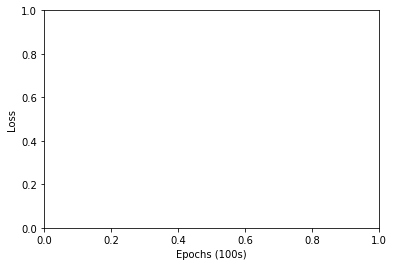

In [20]:
#Let's plot the loss we got during the training procedure
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Epochs (100s)')
plt.plot(all_losses)

## 5. Step - Predict!
Great! We have successfully created our two models for bob and alice in parallel using federated learning! I experimented with federated averaging of the two models, but it turned out that for a batch size of 1, as in the present case, the model loss was diverging. Let's try using our models for prediction now, shall we? This is the final reward for our endeavours.

In [50]:
input_line = "Daniele"
model_remote = model_pointers["alice"]
line_tensor = lineToTensor(input_line)
line_tensor
line_remote = line_tensor.send(alice)
hidden = model_remote.initHidden()
hidden_remote = hidden.copy().send(alice)
hidden_remote
with torch.no_grad():
    for i in range(line_remote.shape[0]):
        output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
n_predictions = 3
topv, topi = output.copy().get().topk(n_predictions, 1, True)
topv

predictions = []


for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])



(-1.55) French
(-1.82) Portuguese
(-2.10) German


In [56]:
def predict(model, input_line, worker, n_predictions=3):
    model = model.copy().get()
    print('\n> %s' % input_line)
    model_remote = model.send(worker)
    line_tensor = lineToTensor(input_line)
    line_remote = line_tensor.copy().send(worker)
    #line_tensor = lineToTensor(input_line)
    #output = evaluate(model, line_remote)
    # Get top N categories
    hidden = model_remote.initHidden()
    hidden_remote = hidden.copy().send(worker)
        
    with torch.no_grad():
        for i in range(line_remote.shape[0]):
            output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
    topv, topi = output.copy().get().topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])



Notice how the different models learned may perform different predictions, based on the data that was shown to them.

In [57]:
predict(model_pointers["alice"], "Qing", alice) 




> Qing
(-0.90) Korean
(-2.15) Arabic
(-2.44) German


You may try experimenting with this example right now, for example by increasing or decreasing the amount of epochs and seeing how the two models perform. You may also try to de-commenting the part about federating averaging and check the new resulting loss function. There can be lots of other optimizations we may think of as well!

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star PySyft on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star PySyft](https://github.com/OpenMined/PySyft)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org)

### Join a Code Project!

The best way to contribute to our community is to become a code contributor! At any time you can go to PySyft GitHub Issues page and filter for "Projects". This will show you all the top level Tickets giving an overview of what projects you can join! If you don't want to join a project, but you would like to do a bit of coding, you can also look for more "one off" mini-projects by searching for GitHub issues marked "good first issue".

- [PySyft Projects](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3AProject)
- [Good First Issue Tickets](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)